In [1]:
# pour que le pretty-printer de jupyter se fasse toujours lorsqu'on écrit la variable seule
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# imports utiles
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk

from math import sqrt
from time import time
import os
import joblib
import itertools

# commande à enlever si ipymbl n'est pas installé
%matplotlib widget

# Préparation

## Lecture des données

In [2]:
df = pd.read_json("data.json").set_index('Id')
labels = pd.read_csv("label.csv", index_col='Id')
category_names = pd.read_csv("categories_string.csv")['0'].to_dict()

df['label'] = labels['Category']
df['job'] = labels['Category'].map(category_names)

df

,description,gender,label,job
Id,,,,
0,She is also a Ronald D. Asmus Policy Entrepre...,F,19,professor
1,He is a member of the AICPA and WICPA. Brent ...,M,9,accountant
2,Dr. Aster has held teaching and research posi...,M,19,professor
3,He runs a boutique design studio attending cl...,M,24,architect
4,"He focuses on cloud security, identity and ac...",M,24,architect
...,...,...,...,...
217192,A member of the UWA Cultural Collections Boar...,M,19,professor
217193,Kelly has worked globally leading teams of co...,F,22,psychologist
217194,He's the lead author of a recent study that f...,M,19,professor


## Définition de fonctions

### Fairness

In [3]:
def disparate_impact_df(df):
    counts = df.groupby(['label', 'gender']).size().unstack('gender')
    di = counts[['M', 'F']].max(axis='columns') / counts[['M', 'F']].min(axis='columns')
    di.index = di.index.map(category_names)
    return di.sort_values(ascending=False)

def disparate_impact(labels, genders):
    return disparate_impact_df(pd.DataFrame({'label': labels, 'gender': genders}))

def macro_disparate_impact(labels, genders):
    print("   macro fairness" + 25*" ", round(disparate_impact(labels, genders).mean(), 3))

In [4]:
disparate_impact_df(df)

print("macro disparate impact :", disparate_impact_df(df).mean())

label
dietitian            12.619048
rapper               11.234375
nurse                10.179805
surgeon               6.433708
yoga_teacher          5.695035
dj                    5.648000
software_engineer     5.623165
paralegal             5.320261
composer              5.139241
model                 4.739191
interior_designer     4.231707
comedian              3.750725
architect             3.445205
pastor                3.158333
chiropractor          2.595908
filmmaker             1.958393
dentist               1.875989
photographer          1.855527
accountant            1.764393
attorney              1.648466
psychologist          1.615404
physician             1.533726
teacher               1.455034
professor             1.228106
personal_trainer      1.217033
painter               1.168466
journalist            1.008003
poet                  1.006545
dtype: float64

macro disparate impact : 3.898171170378377


### Utilities

In [5]:
import re
from time import time
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score

def show_confusion_matrix(y_true, y_pred):
    _=metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_true, y_pred)).plot(include_values=False)
    
def score_report(y_true, y_pred):
    r = classification_report(y_true, y_pred, target_names=category_names.values()).split("\n")
    for line in [re.sub("\\s+[^ ]+$","",e) for e in r[:1] + r[31:-1]]: print(line)
        
def print_score_report(clf, Y_train, y_pred_train, Y_test, y_pred_test, gender_train, gender_test):
    print("train")
    score_report(Y_train, y_pred_train)
    macro_disparate_impact(y_pred_train, gender_train)
    print("test")
    score_report(Y_test, y_pred_test)
    macro_disparate_impact(y_pred_test, gender_test)
    
def fit_model_test(model, X_train, X_test, Y_train, Y_test, test_on_train_set=True, test_on_test_set=True):
    t0 = time()
    model.fit(X_train, Y_train)
    print("train time: %0.3fs" % (time() - t0))
    
    if test_on_train_set:
        t0 = time()
        Y_pred_train = model.predict(X_train)
        print("test time (train set): %0.3fs" % (time() - t0))
    else: Y_pred_train = None
    
    if test_on_test_set:
        t0 = time()
        Y_pred_test = model.predict(X_test)
        print("test time (test set) : %0.3fs" % (time() - t0))
    else: Y_pred_test = None
    
    return [Y_pred_train, Y_pred_test]

In [6]:
import contextlib
import joblib
import os


@contextlib.contextmanager
def persist(name:str, dump:bool=True):
    if type(name) != str:
        raise TypeError("name must be a string")
    try:
        try: 
            var = globals()[name]
            yield var
        except KeyError:
            if os.path.isfile(name):
                print("loading " + name)
                yield joblib.load(name)
            else: yield
    finally:
        if dump:
            try:
                var = globals()[name]
                if var != None and not os.path.isfile(name):
                    joblib.dump(var, name)
                    print("dumped " + name)
            except KeyError: raise RuntimeError(name + " is not defined")

# Visualisation

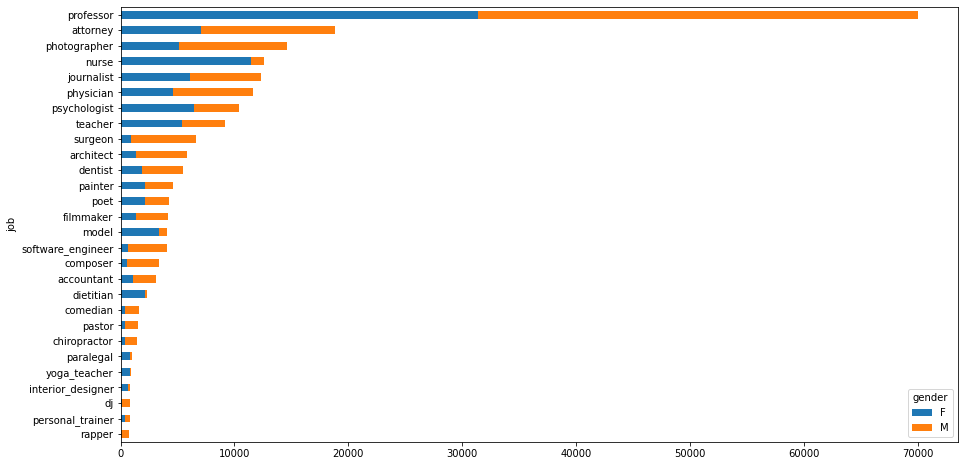

In [8]:
d=df.groupby(['job', 'gender']).size().unstack('gender')
d['sum']=d['F']+d['M']
_=d.sort_values(by='sum').drop(columns='sum').plot.barh(figsize=(15,8), stacked=True)

# Prétraitement

### Fonctions de prétraitement

In [7]:
def preprocess(text):
    # remove : not charater or space, digit, words with size < 3
    # to lowercase
    return re.sub(r'[^\w\s]|\d|\b\w{1,2}\b', ' ', str(text)).strip().lower()


lemmatizer = nltk.stem.WordNetLemmatizer()
# tokenizer with lemmatization
def tokenize(text):
    return [lemmatizer.lemmatize(word) for word in nltk.word_tokenize(text)]


def full_preprocessing(text):
    l = tokenize(preprocess(text))
    return " ".join([w for w in l if w not in stop_words])

### Stop words

In [8]:
try: nltk.data.find('corpora/stopwords')
except LookupError: nltk.download('stopwords')
try: nltk.data.find('tokenizers/punkt')
except LookupError: nltk.download('punkt')
try: nltk.data.find('corpora/wordnet')
except LookupError: nltk.download('wordnet')
try: nltk.data.find('corpora/names')
except LookupError: nltk.download('names')

english_stopwords = nltk.corpus.stopwords.words("english")
male_names = [t.lower() for t in nltk.corpus.names.words('male.txt')]
female_names = [t.lower() for t in nltk.corpus.names.words('female.txt')]

# stopwords = common english + male and female names
stop_words = english_stopwords + list(
    itertools.chain.from_iterable(
        [tokenize(preprocess(t)) for t in male_names])) + list(
            itertools.chain.from_iterable(
                [tokenize(preprocess(t)) for t in female_names]))

FileSystemPathPointer('C:\\Users\\Pierre\\AppData\\Roaming\\nltk_data\\corpora\\stopwords')

FileSystemPathPointer('C:\\Users\\Pierre\\AppData\\Roaming\\nltk_data\\tokenizers\\punkt\\PY3')

FileSystemPathPointer('C:\\Users\\Pierre\\AppData\\Roaming\\nltk_data\\corpora\\wordnet')

FileSystemPathPointer('C:\\Users\\Pierre\\AppData\\Roaming\\nltk_data\\corpora\\names')

### Exemple

In [13]:
text = df.description[0]
text
full_preprocessing(text)

' She is also a Ronald D. Asmus Policy Entrepreneur Fellow with the German Marshall Fund and is a Visiting Fellow at the Centre for International Studies (CIS) at the University of Oxford. This commentary first appeared at Sada, an online journal published by the Carnegie Endowment for International Peace.'

'also asmus policy entrepreneur fellow german fund visiting fellow centre international study ci university oxford commentary first appeared online journal published carnegie endowment international peace'

# Modèles

## TF - IDF

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

with persist('tfidf_vectorizer') as tfidf_vectorizer:
    if tfidf_vectorizer == None:
        tfidf_vectorizer = TfidfVectorizer(strip_accents='unicode',
                                            preprocessor=preprocess,
                                            tokenizer=tokenize,
                                            stop_words=stop_words,
                                            sublinear_tf=True).fit(df.description)

with persist('custom_X') as custom_X:
    if custom_X == None:
        custom_X = tfidf_vectorizer.transform(df.description)

X = custom_X
X.shape

loading tfidf_vectorizer
loading custom_X


(217197, 194282)

In [14]:
text
tfidf_vectorizer.inverse_transform(tfidf_vectorizer.transform([text]))

' She is also a Ronald D. Asmus Policy Entrepreneur Fellow with the German Marshall Fund and is a Visiting Fellow at the Centre for International Studies (CIS) at the University of Oxford. This commentary first appeared at Sada, an online journal published by the Carnegie Endowment for International Peace.'

[array(['visiting', 'university', 'study', 'published', 'policy', 'peace',
        'oxford', 'online', 'journal', 'international', 'german', 'fund',
        'first', 'fellow', 'entrepreneur', 'endowment', 'commentary', 'ci',
        'centre', 'carnegie', 'asmus', 'appeared', 'also'], dtype='<U92')]

### Entraînement

In [13]:
X_train, X_test, Y_train, Y_test, gender_train, gender_test = train_test_split(X,
                                                                               df.label,
                                                                               df.gender,
                                                                               test_size=0.2,
                                                                               random_state=211101)

# smaller set
N_train = 50_000
np.random.seed(211101)
idxs = np.random.choice(X.shape[0], N_train, replace=False)
x=X[idxs, :]
x_train, x_test, y_train, y_test, g_train, g_test = train_test_split(x,
                                                    df.label.iloc[idxs],
                                                    df.gender.iloc[idxs],
                                                    test_size=0.2,
                                                    random_state=211101)

#### KNN

In [16]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=int(sqrt(x_train.shape[0])), n_jobs=-1)

y_pred_train, y_pred_test = fit_model_test(model, x_train, x_test, y_train, y_test)

train time: 0.016s
test time (train set): 61.427s
test time (test set) : 14.392s


In [17]:
print_score_report(model, y_train, y_pred_train, y_test, y_pred_test, g_train, g_test)

train
                   precision    recall  f1-score
         accuracy                           0.68
        macro avg       0.79      0.47      0.55
     weighted avg       0.72      0.68      0.65
   macro fairness                          4.19
test
                   precision    recall  f1-score
         accuracy                           0.68
        macro avg       0.80      0.47      0.54
     weighted avg       0.72      0.68      0.65
   macro fairness                          3.32


In [ ]:
show_confusion_matrix(y_train, y_pred_train)
show_confusion_matrix(y_test, y_pred_test)

#### Random Forest

In [25]:
from sklearn.ensemble import RandomForestClassifier

random_forest_clf = RandomForestClassifier(n_estimators=100,
                                           max_depth=150,
                                           n_jobs=-1,
                                           random_state=211101)
y_pred_train, y_pred_test = fit_model_test(random_forest_clf, x_train, x_test, y_train, y_test)

train time: 98.431s
test time (train set): 1.046s
test time (test set) : 0.300s


In [29]:
print_score_report(random_forest_clf, y_train, y_pred_train, y_test, y_pred_test, g_train, g_test)

train
                   precision    recall  f1-score
         accuracy                           0.99
        macro avg       1.00      0.98      0.99
     weighted avg       0.99      0.99      0.99
   macro fairness                          3.895
test
                   precision    recall  f1-score
         accuracy                           0.65
        macro avg       0.79      0.39      0.47
     weighted avg       0.72      0.65      0.62
   macro fairness                          5.827


In [ ]:
show_confusion_matrix(y_train, y_pred_train)
show_confusion_matrix(y_test, y_pred_test)

#### SGD

In [187]:
from sklearn.linear_model import SGDClassifier

model = SGDClassifier(max_iter=10000,
                    tol=1e-5,
                    loss='hinge',
                    penalty='l2',
                    n_jobs=-1,
                    random_state=211101)

Y_pred_train, Y_pred_test = fit_model_test(model, X_train, X_test, Y_train, Y_test)

train time: 14.682s
test time (train set): 0.258s
test time (test set) : 0.125s


In [188]:
print_score_report(model, Y_train, Y_pred_train, Y_test, Y_pred_test, gender_train, gender_test)

train
                   precision    recall  f1-score
         accuracy                           0.80
        macro avg       0.81      0.72      0.75
     weighted avg       0.81      0.80      0.80
   macro fairness                          3.416
test
                   precision    recall  f1-score
         accuracy                           0.78
        macro avg       0.76      0.66      0.69
     weighted avg       0.77      0.78      0.77
   macro fairness                          3.078


In [74]:
show_confusion_matrix(Y_train, Y_pred_train)
show_confusion_matrix(Y_test, Y_pred_test)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

#### Naive bayes

In [189]:
from sklearn.naive_bayes import ComplementNB

model = ComplementNB()

Y_pred_train, Y_pred_test = fit_model_test(model, X_train, X_test, Y_train, Y_test)

train time: 0.515s
test time (train set): 0.209s
test time (test set) : 0.067s


In [190]:
print_score_report(model, Y_train, Y_pred_train, Y_test, Y_pred_test, gender_train, gender_test)

train
                   precision    recall  f1-score
         accuracy                           0.79
        macro avg       0.86      0.68      0.73
     weighted avg       0.80      0.79      0.78
   macro fairness                          3.58
test
                   precision    recall  f1-score
         accuracy                           0.71
        macro avg       0.76      0.55      0.60
     weighted avg       0.72      0.71      0.69
   macro fairness                          3.147


In [ ]:
show_confusion_matrix(Y_train, Y_pred_train)
show_confusion_matrix(Y_test, Y_pred_test)

#### SVM

##### Linear

In [22]:
from sklearn.svm import LinearSVC

model = LinearSVC(max_iter=1e9, # default : 1000
                  tol=1e-5, # default : 1e-3
                  C=0.1, # default : 1
                  dual=False,
                  random_state=211101)

Y_pred_train, Y_pred_test = fit_model_test(model, X_train, X_test, Y_train, Y_test)

print_score_report(model, Y_train, Y_pred_train, Y_test, Y_pred_test, gender_train, gender_test)

train time: 39.160s
test time (train set): 0.201s
test time (test set) : 0.052s
train
                   precision    recall  f1-score
         accuracy                           0.86
        macro avg       0.86      0.80      0.83
     weighted avg       0.86      0.86      0.86
   macro fairness                          3.802
test
                   precision    recall  f1-score
         accuracy                           0.80
        macro avg       0.80      0.70      0.74
     weighted avg       0.80      0.80      0.79
   macro fairness                          3.267


##### RBF

### Entraînement avec Feature selection

In [15]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import chi2

X_selected = SelectPercentile(chi2, percentile=10).fit_transform(X, df.label)
X_selected.shape
X_s_train, X_s_test, Y_s_train, Y_s_test, G_s_train, G_s_test = train_test_split(X_selected,
                                                                                 df.label,
                                                                                 df.gender,
                                                                                 test_size=0.2,
                                                                                 random_state=211101)

# smaller set
N_train = 50_000
np.random.seed(211101)
idxs = np.random.choice(X.shape[0], N_train, replace=False)
x_selected=X[idxs, :]
x_s_train, x_s_test, y_s_train, y_s_test, g_s_train, g_s_test = train_test_split(x_selected,
                                                                                 df.label.iloc[idxs],
                                                                                 df.gender.iloc[idxs],
                                                                                 test_size=0.2,
                                                                                 random_state=211101)

(217197, 19429)

#### KNN

In [32]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=int(sqrt(x_train.shape[0])), n_jobs=-1)

y_s_pred_train, y_s_pred_test = fit_model_test(model, x_s_train, x_s_test, y_s_train, y_s_test)

train time: 0.011s
test time (train set): 59.348s
test time (test set) : 13.073s


In [33]:
print_score_report(model, y_s_train, y_s_pred_train, y_s_test, y_s_pred_test, g_s_train, g_s_test)

train
                   precision    recall  f1-score
         accuracy                           0.68
        macro avg       0.79      0.47      0.55
     weighted avg       0.72      0.68      0.65
   macro fairness                          4.19
test
                   precision    recall  f1-score
         accuracy                           0.68
        macro avg       0.80      0.47      0.54
     weighted avg       0.72      0.68      0.65
   macro fairness                          3.32


In [34]:
show_confusion_matrix(y_s_train, y_s_pred_train)
show_confusion_matrix(y_s_test, y_s_pred_test)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

#### Random Forest

In [38]:
from sklearn.ensemble import RandomForestClassifier

random_forest_clf = RandomForestClassifier(n_estimators=100,
                                           max_depth=150,
                                           n_jobs=-1,
                                           random_state=211101)

y_s_pred_train, y_s_pred_test = fit_model_test(random_forest_clf, x_s_train, x_s_test, y_s_train, y_s_test)

train time: 101.359s
test time (train set): 1.114s
test time (test set) : 0.318s


In [41]:
print_score_report(model, y_s_train, y_s_pred_train, y_s_test, y_s_pred_test, g_s_train, g_s_test)

train
                   precision    recall  f1-score
         accuracy                           0.99
        macro avg       1.00      0.98      0.99
     weighted avg       0.99      0.99      0.99
   macro fairness                          3.895
test
                   precision    recall  f1-score
         accuracy                           0.65
        macro avg       0.79      0.39      0.47
     weighted avg       0.72      0.65      0.62
   macro fairness                          5.827


In [42]:
show_confusion_matrix(y_s_train, y_s_pred_train)
show_confusion_matrix(y_s_test, y_s_pred_test)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

#### SGD

In [16]:
from sklearn.linear_model import SGDClassifier

model = SGDClassifier(max_iter=10000,
                    tol=1e-5,
                    loss='hinge',
                    penalty='l2',
                    n_jobs=-1,
                    random_state=211101)

Y_s_pred_train, Y_s_pred_test = fit_model_test(model, X_s_train, X_s_test, Y_s_train, Y_s_test)

train time: 5.962s
test time (train set): 0.125s
test time (test set) : 0.032s


In [171]:
print_score_report(model, Y_s_train, Y_s_pred_train, Y_s_test, Y_s_pred_test, G_s_train, G_s_test)

train
                   precision    recall  f1-score
         accuracy                           0.79
        macro avg       0.78      0.70      0.73
     weighted avg       0.79      0.79      0.78
   macro fairness                          3.276
test
                   precision    recall  f1-score
         accuracy                           0.77
        macro avg       0.76      0.66      0.69
     weighted avg       0.77      0.77      0.77
   macro fairness                          3.022


In [ ]:
show_confusion_matrix(Y_s_train, Y_s_pred_train)
show_confusion_matrix(Y_s_test, Y_s_pred_test)

#### Naive bayes

In [140]:
from sklearn.naive_bayes import ComplementNB

model = ComplementNB()

Y_s_pred_train, Y_s_pred_test = fit_model_test(model, X_s_train, X_s_test, Y_s_train, Y_s_test)

train time: 0.199s
test time (train set): 0.102s
test time (test set) : 0.034s


In [141]:
print_score_report(model, Y_s_train, Y_s_pred_train, Y_s_test, Y_s_pred_test, G_s_train, G_s_test)

train
                   precision    recall  f1-score
         accuracy                           0.74
        macro avg       0.78      0.65      0.69
     weighted avg       0.75      0.74      0.73
test
                   precision    recall  f1-score
         accuracy                           0.73
        macro avg       0.75      0.59      0.63
     weighted avg       0.73      0.73      0.71


In [ ]:
show_confusion_matrix(Y_s_train, Y_s_pred_train)
show_confusion_matrix(Y_s_test, Y_s_pred_test)

 #### SVM

In [18]:
from sklearn.svm import LinearSVC

model = LinearSVC(max_iter=1e9, # default : 1000
                  tol=1e-5, # default : 1e-3
                  C=0.1, # default : 1
                  dual=False,
                  random_state=211101)

Y_s_pred_train, Y_s_pred_test = fit_model_test(model, X_s_train, X_s_test, Y_s_train, Y_s_test)
print()
print_score_report(model, Y_s_train, Y_s_pred_train, Y_s_test, Y_s_pred_test, G_s_train, G_s_test)

train time: 27.187s
test time (train set): 0.107s
test time (test set) : 0.027s

train
                   precision    recall  f1-score
         accuracy                           0.83
        macro avg       0.83      0.76      0.79
     weighted avg       0.83      0.83      0.82
   macro fairness                          3.683
test
                   precision    recall  f1-score
         accuracy                           0.80
        macro avg       0.80      0.70      0.74
     weighted avg       0.80      0.80      0.79
   macro fairness                          3.258


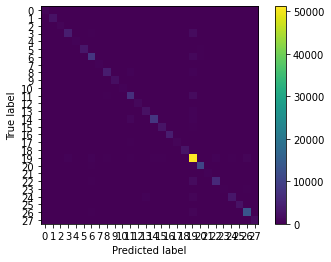

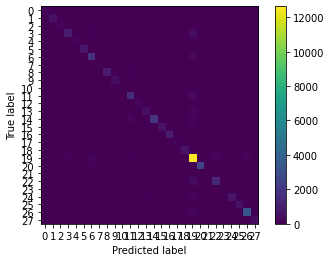

In [25]:
show_confusion_matrix(Y_s_train, Y_s_pred_train)
show_confusion_matrix(Y_s_test, Y_s_pred_test)

## Catboost

### With Gender

In [17]:
df2 = df.drop(['label', 'job'], axis='columns')
df2['description'] = df['description'].str.lower()
df2.loc[df2['gender'] == 'M', 'gender'] = 0
df2.loc[df2['gender'] == 'F', 'gender'] = 1

df2.head()

x_catboost_train, x_catboost_test, y_catboost_train, y_catboost_test, g_cb_train, g_cb_test = train_test_split(
    df2, df.label, df.gender, test_size=0.2, random_state=211101)

,description,gender
Id,,
0,she is also a ronald d. asmus policy entrepre...,1
1,he is a member of the aicpa and wicpa. brent ...,0
2,dr. aster has held teaching and research posi...,0
3,he runs a boutique design studio attending cl...,0
4,"he focuses on cloud security, identity and ac...",0


In [20]:
from catboost import Pool, CatBoostClassifier

catboost_filename = 'catboost_model_with_gender.dump'

if os.path.isfile(catboost_filename):
    model = CatBoostClassifier().load_model(catboost_filename)
else:
    train_pool = Pool(x_catboost_train,
                      y_catboost_train,
                      text_features=['description'])
    test_pool = Pool(x_catboost_test,
                     y_catboost_test,
                     text_features=['description'])

    catboost_params = {
        'iterations': 3000,
        'learning_rate': 0.1,
        'task_type': 'GPU',
        'devices': '0-1',
        'early_stopping_rounds': 5000,
        'use_best_model': True,
        'verbose': False
    }
    model = CatBoostClassifier(**catboost_params)
    model.fit(train_pool, eval_set=test_pool, plot=True)

    model.save_model(catboost_filename)

y_catboost_pred_train = model.predict(x_catboost_train)
x_catboost_pred_test = model.predict(x_catboost_test)

In [21]:
print_score_report(model,
                   y_catboost_train, y_catboost_pred_train.flatten(),
                   y_catboost_test, x_catboost_pred_test.flatten(),
                   g_cb_train, g_cb_test)

train
                   precision    recall  f1-score
         accuracy                           0.80
        macro avg       0.75      0.75      0.75
     weighted avg       0.81      0.80      0.80
   macro fairness                          5.406
test
                   precision    recall  f1-score
         accuracy                           0.80
        macro avg       0.76      0.75      0.75
     weighted avg       0.81      0.80      0.80
   macro fairness                          5.472


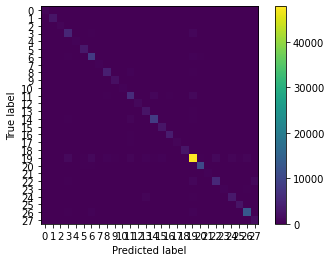

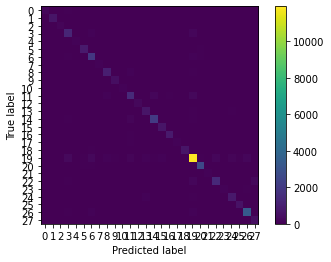

In [26]:
show_confusion_matrix(y_catboost_train, y_catboost_pred_train)
show_confusion_matrix(y_catboost_test, x_catboost_pred_test)

### Without Gender

In [8]:
df3 = df2.drop(['gender'], axis='columns')
df3.head()

x_catboost_train, x_catboost_test, y_catboost_train, y_catboost_test, g_cb_train, g_cb_test = train_test_split(
    df3, df.label, df.gender, test_size=0.2, random_state=211101)

,description
Id,
0,she is also a ronald d. asmus policy entrepre...
1,he is a member of the aicpa and wicpa. brent ...
2,dr. aster has held teaching and research posi...
3,he runs a boutique design studio attending cl...
4,"he focuses on cloud security, identity and ac..."


In [ ]:
from catboost import Pool, CatBoostClassifier

catboost_filename = 'catboost_model_without_gender.dump'

if os.path.isfile(catboost_filename):
    model = CatBoostClassifier().load_model(catboost_filename)
else:
    train_pool = Pool(x_catboost_train,
                      y_catboost_train,
                      text_features=['description'])
    test_pool = Pool(x_catboost_test,
                     y_catboost_test,
                     text_features=['description'])

    catboost_params = {
        'iterations': 3000,
        'learning_rate': 0.1,
        'task_type': 'GPU',
        'devices': '0-1',
        'early_stopping_rounds': 5000,
        'use_best_model': True,
        'verbose': False
    }
    model = CatBoostClassifier(**catboost_params)
    model.fit(train_pool, eval_set=test_pool, plot=True)

    model.save_model(catboost_filename)

y_catboost_pred_train = model.predict(x_catboost_train)
y_catboost_pred_test = model.predict(x_catboost_test)

In [11]:
print_score_report(model,
                   y_catboost_train, y_catboost_pred_train.flatten(),
                   y_catboost_test, x_catboost_pred_test.flatten(),
                   g_cb_train, g_cb_test)

train
                   precision    recall  f1-score
         accuracy                           0.88
        macro avg       0.86      0.85      0.85
     weighted avg       0.88      0.88      0.88
   macro fairness                          4.853
test
                   precision    recall  f1-score
         accuracy                           0.80
        macro avg       0.75      0.71      0.73
     weighted avg       0.80      0.80      0.80
   macro fairness                          5.307


Ne pas utiliser le genre n'améliore que très peu la fairness.

## Word embedding

## RoBERTa

See attached notebook